In [1]:
from moarchiving.get_archive import get_mo_archive
from moarchiving.moarchiving_utils import my_lexsort
from moarchiving.tests.point_sampling import get_non_dominated_points

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import pandas as pd
import time
import numpy as np
import os
import copy

In [2]:
def plot_performance(plot_function="add", xlabel="Archive size", 
                     ylabel="Time [s]", title="", logx=True, logy=True, colors=None):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for dim, ax in zip([2, 3, 4], axs):
        f_names = os.listdir("test_results")
        f_names = [f for f in f_names if f"{plot_function}_{dim}D" in f]
        if len(f_names) == 0:
            continue
        f_names.sort()
        f_name = f_names[-1]
    
        df = pd.read_csv(f"test_results/{f_name}", index_col=0)
    
        if colors is None:
            colors = list(mcolors.TABLEAU_COLORS.keys())
        
        for i, col in enumerate(df.columns):
            # make polynomial fit ignoring the nan values
            y = df[col]
            # shorten the data to the first nan value
            if np.isnan(y).any():
                idx = np.where(np.isnan(y))[0][0]
                y = y[:idx]
            x = df.index[:len(y)]
    
            ax.plot(x, y, '-o', label=col, color=colors[i])
    
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")
        ax.legend()
        ax.grid()
        ax.set_title(f"{dim}D")
        
    plt.suptitle(title)
    plt.show()


In [3]:
def save_results(data, index, n_dim, function):
    df = pd.DataFrame(data, index=index)
    date = time.strftime("%m%d-%H%M%S")
    df.to_csv(f"test_results/{function}_{n_dim}D_{date}.csv")

In [4]:
archive_sizes = [2 ** i for i in range(21)]
# check if directory test_results exists
if not os.path.exists("test_results"):
    os.makedirs("test_results")

In [5]:
def test_add(test_archive_sizes, n_repeats=100, n_points_to_add=1, n_dim=3, time_limit=100):
    ref_point = [1] * n_dim

    times = []
    archive_sizes_tested = []
    print(f"test add {n_points_to_add} points in {n_dim}D")

    for archive_size in test_archive_sizes:
        add_points = get_non_dominated_points(n_repeats * n_points_to_add, n_dim=n_dim)
        if archive_size < 4000:
            moa = [get_mo_archive(get_non_dominated_points(archive_size, n_dim=n_dim), ref_point, n_obj=n_dim)
                   for _ in range(n_repeats)]
            t0 = time.time()
            for i in range(n_repeats):
                if n_points_to_add == 1:
                    moa[i].add(add_points[i])
                else:
                    moa[i].add_list(add_points[i * n_points_to_add: (i + 1) * n_points_to_add])
            t1 = time.time()
        else:
            moa = get_mo_archive(get_non_dominated_points(archive_size, n_dim=n_dim), ref_point, n_obj=n_dim)
            
            t0 = time.time()
            for i in range(n_repeats):
                if n_points_to_add == 1:
                    moa.add(add_points[i])
                else:
                    moa.add_list(add_points[i * n_points_to_add: (i + 1) * n_points_to_add])
            t1 = time.time()

        times.append((t1 - t0) / n_repeats)
        archive_sizes_tested.append(archive_size)

        print(f".", end="")
        if t1 - t0 > time_limit:
            break
    save_results(data={"times": times}, index=archive_sizes_tested, n_dim=n_dim, function=f"add{n_points_to_add}")
    print()

# Test adding one point to the archive

test add 1 points in 2D
.....................
test add 1 points in 3D
...............
test add 1 points in 4D
.........


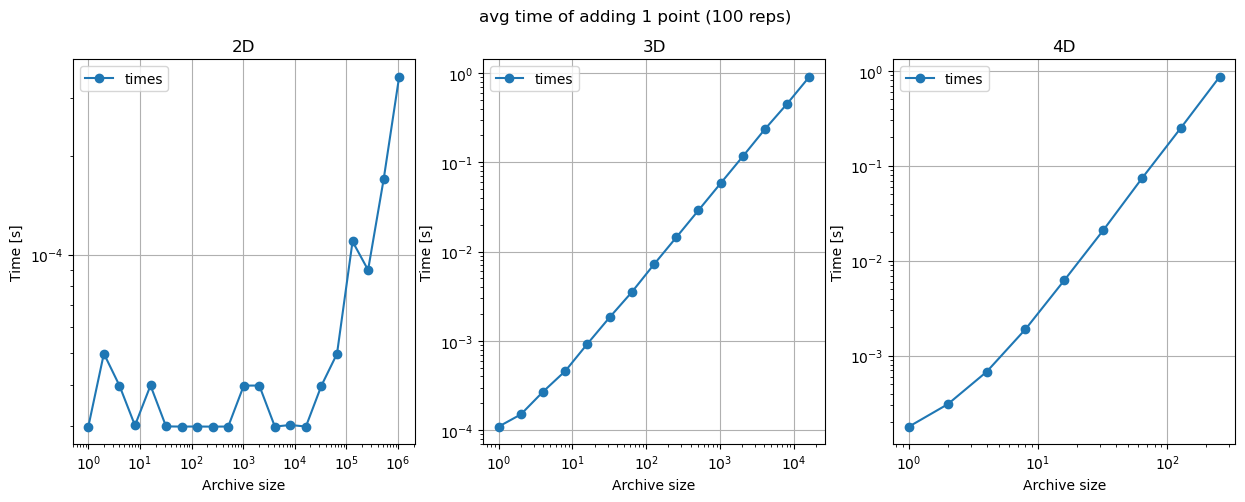

In [6]:
for dim in [2, 3, 4]:
    test_add(test_archive_sizes=archive_sizes, n_dim=dim, time_limit=60)
plot_performance(plot_function=f"add1", title=f"avg time of adding 1 point (100 reps)")

# Test adding 100 points to the archive

test add 100 points in 2D
.....................
test add 100 points in 3D
.................
test add 100 points in 4D
...........


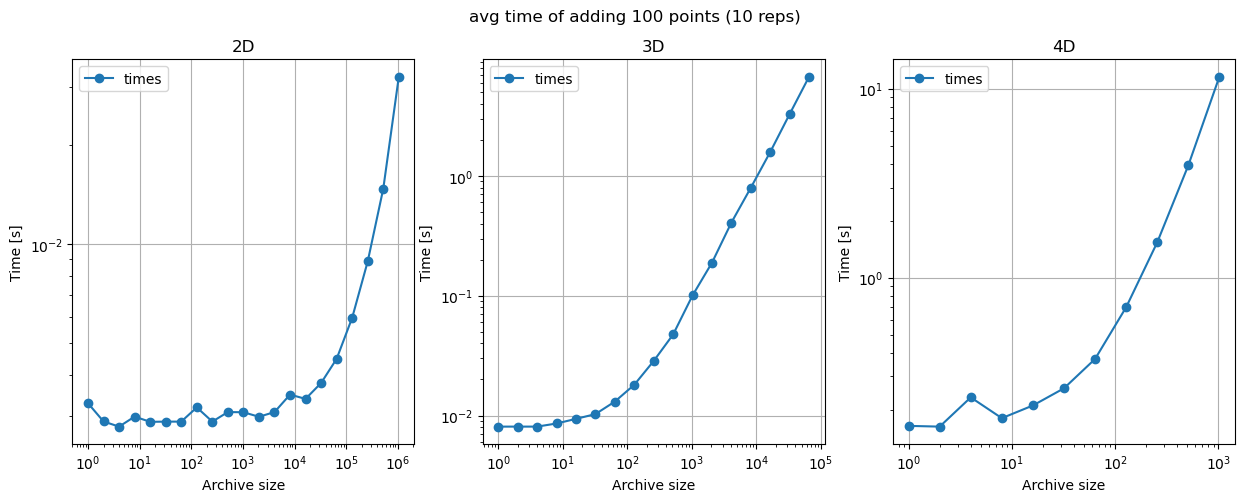

In [7]:
for dim in [2, 3, 4]:
    test_add(test_archive_sizes=archive_sizes, n_dim=dim, time_limit=60, n_points_to_add=100, n_repeats=10)
plot_performance(plot_function=f"add100", title=f"avg time of adding 100 points (10 reps)")

# Test distance to pareto front

In [8]:
def test_distance_to_pareto_front(test_archive_sizes, n_dim=3, time_limit=10, n_points=1):
    print(f"test distance to pareto front in {n_dim}D")
    times = {
        "spherical": [],
        "linear": [],
    }
    archive_sizes_tested = []
    for archive_size in test_archive_sizes:
        # read the data points and the reference point from the file
        moa = {
            "spherical": get_mo_archive(get_non_dominated_points(archive_size, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_mo_archive(get_non_dominated_points(archive_size, mode="linear", n_dim=n_dim), [1] * n_dim),
        }

        test_points = get_non_dominated_points(n_points, n_dim=n_dim, mode="spherical")
        test_points = [[random.uniform(p[i] + 0.5 * (1 - p[i]), 1) for i in range(n_dim)] for p in test_points]
        
        t0 = time.time()
        for p in test_points:
            moa["spherical"].distance_to_pareto_front(p)
        t1 = time.time()
        
        test_points = get_non_dominated_points(n_points, n_dim=n_dim, mode="linear")
        test_points = [[random.uniform(p[i] + 0.5 * (1 - p[i]), 1) for i in range(n_dim)] for p in test_points]

        t2 = time.time()
        for p in test_points:
            moa["linear"].distance_to_pareto_front(p)
        t3 = time.time()

        times[f"spherical"].append(max(t1 - t0, 10e-6))
        times[f"linear"].append(max(t3 - t2, 10e-6))
        archive_sizes_tested.append(archive_size)
        print(f".", end="")

        if times[f"spherical"][-1] > time_limit or times[f"linear"][-1] > time_limit:
            break
    print()
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function=f"dist_to_pareto{n_points}")


test distance to pareto front in 2D
.....................
test distance to pareto front in 3D
...................
test distance to pareto front in 4D
.........


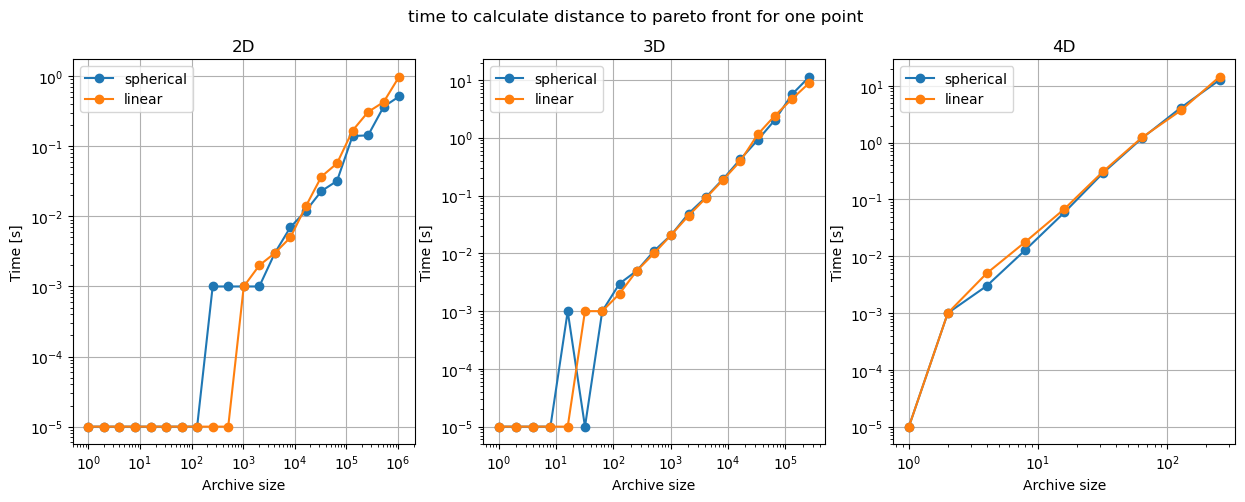

In [9]:
for dim in [2, 3, 4]:
    test_distance_to_pareto_front(archive_sizes, n_dim=dim, time_limit=10, n_points=1)
plot_performance(plot_function="dist_to_pareto1", title=f"time to calculate distance to pareto front for one point")

test distance to pareto front in 2D
..................
test distance to pareto front in 3D
................
test distance to pareto front in 4D
.........


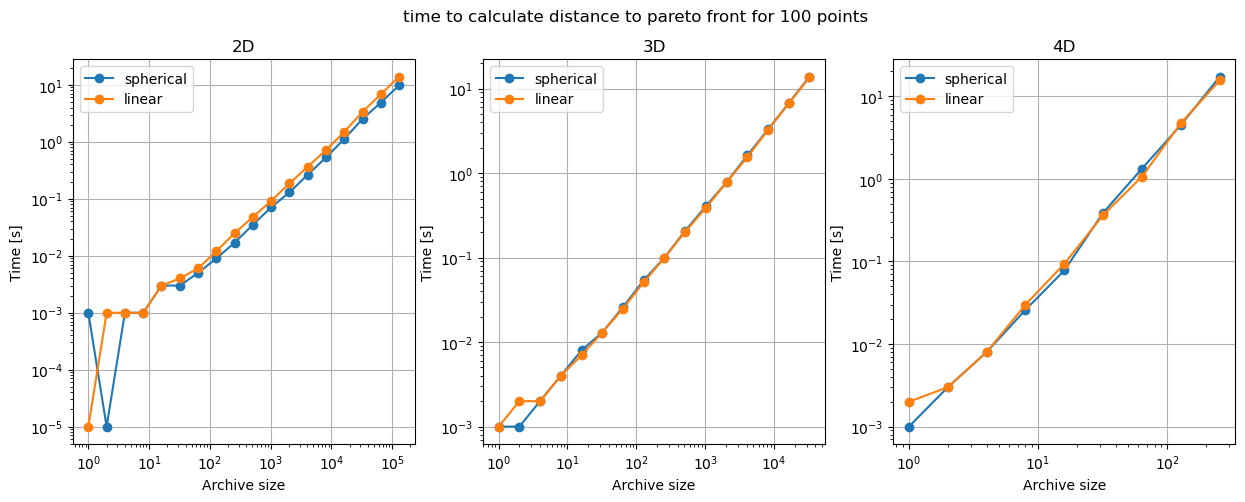

In [10]:
for dim in [2, 3, 4]:
    test_distance_to_pareto_front(archive_sizes, n_dim=dim, time_limit=10, n_points=100)
plot_performance(plot_function="dist_to_pareto100", title=f"time to calculate distance to pareto front for 100 points")

In [11]:
def test_lexsort(test_archive_sizes, n_dim=3):
    time_np = []
    time_my = []

    print(f"test lexsort in {n_dim}D")
    for n in test_archive_sizes:
        pts = np.random.rand(n, n_dim)
        t0 = time.time()
        my_lexsort([pts[:, i] for i in range(n_dim)])
        t1 = time.time()
        np.lexsort([pts[:, i] for i in range(n_dim)])
        t2 = time.time()

        time_my.append(max(t1 - t0, 10e-6))
        time_np.append(max(t2 - t1, 10e-6))
        print(f".", end="")
        
    print()
    save_results(data={"my_lexsort": time_my, "np_lexsort": time_np},
                 index=test_archive_sizes, n_dim=n_dim, function="lexsort")

test lexsort in 2D
.....................
test lexsort in 3D
.....................
test lexsort in 4D
.....................


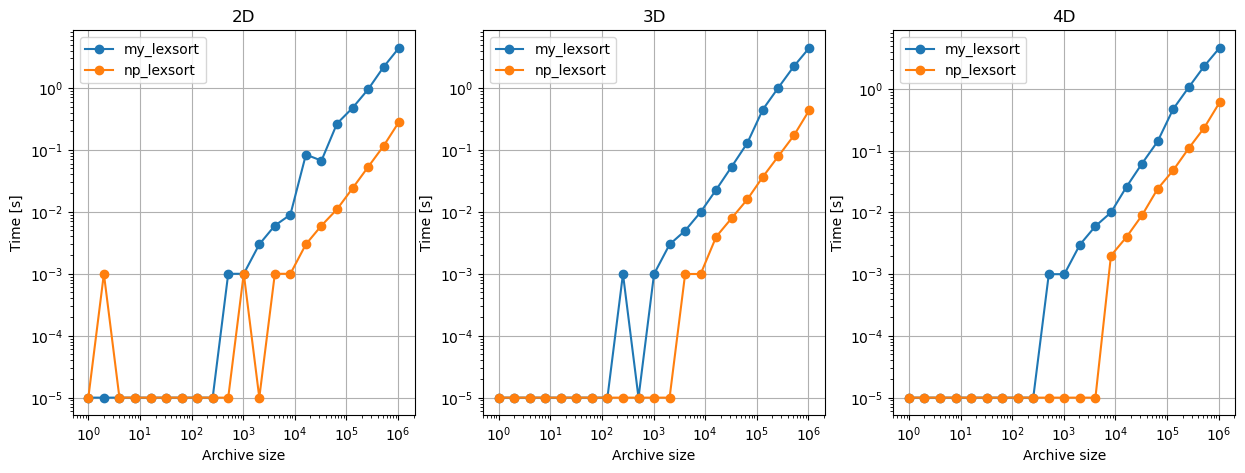

In [12]:
for dim in [2, 3, 4]:
    test_lexsort(archive_sizes, n_dim=dim)
plot_performance(plot_function="lexsort")

## Contributing hypervolume

In [13]:
def test_contributing_hypervolume(test_archive_sizes, n_dim=3, n_reps=10, time_limit=10):
    times = {
        "spherical": [],
        "linear": []
    }

    print(f"test contributing hypervolume in {n_dim}D")
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        points = {
            "spherical": get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim),
        }
        moa = {
            "spherical": get_mo_archive(points["spherical"], [1] * n_dim),
            "linear": get_mo_archive(points["linear"], [1] * n_dim),
        }
        
        t0 = time.time()
        _ = [moa["spherical"].contributing_hypervolume(p) for p in points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].contributing_hypervolume(p) for p in points["linear"]]
        t2 = time.time()
        
        times["spherical"].append(max((t1 - t0) / n_reps, 10e-6))
        times["linear"].append(max((t2 - t1) / n_reps, 10e-6))
        archive_sizes_tested.append(n_points_archive)

        print(f".", end="")
        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
            
    print()
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="contributing_hypervolume")


test contributing hypervolume in 2D
................
test contributing hypervolume in 3D
..........
test contributing hypervolume in 4D
........


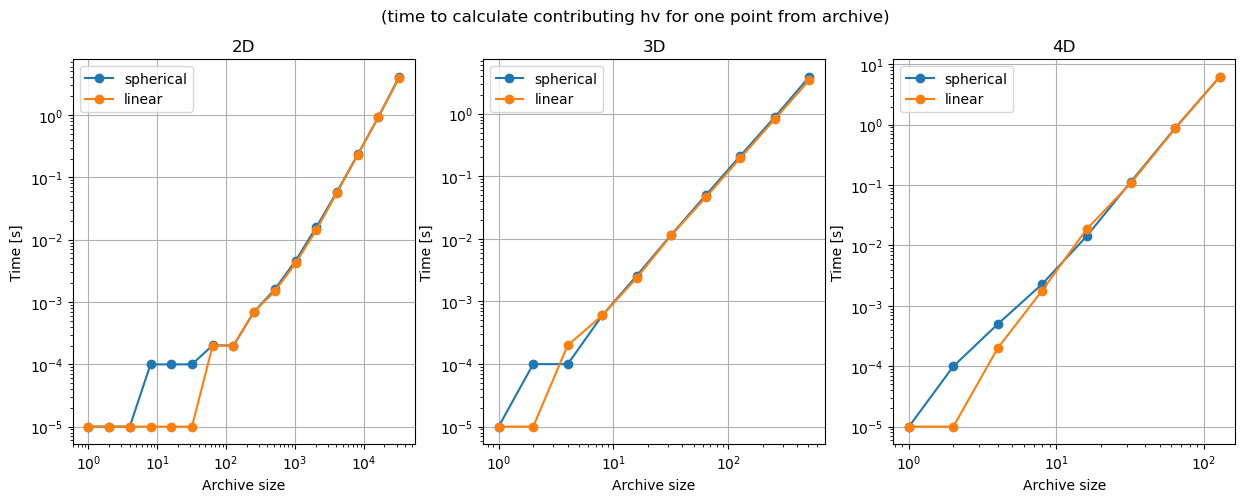

In [14]:
for dim in [2, 3, 4]:
    test_contributing_hypervolume(archive_sizes, n_dim=dim, time_limit=10)
plot_performance(plot_function="contributing_hypervolume",
                 title="(time to calculate contributing hv for one point from archive)")

## Hypervolume improvement

In [15]:
def test_hypervolume_improvement(test_archive_sizes, time_limit=10, n_dim=3, n_reps=10):

    print(f"test hypervolume improvement in {n_dim}D")
    times = {
        "times_spherical": [],
        "times_linear": [],
    }
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        moa = {
            "spherical": get_mo_archive(get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_mo_archive(get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim), [1] * n_dim)
        }
        new_points = {
            "spherical": get_non_dominated_points(n_reps, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_reps, mode="linear", n_dim=n_dim)
        }
                
        t0 = time.time()
        _ = [moa["spherical"].hypervolume_improvement(p) for p in new_points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].hypervolume_improvement(p) for p in new_points["linear"]]
        t2 = time.time()

        times["times_spherical"].append(max((t1 - t0) / n_reps, 10e-6))
        times[f"times_linear"].append(max((t2 - t1) / n_reps, 10e-6))
        archive_sizes_tested.append(n_points_archive)
                
        print(f".", end="")

        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    print()
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="hypervolume_improvement")

test hypervolume improvement in 2D
.....................
test hypervolume improvement in 3D
....................
test hypervolume improvement in 4D
.........


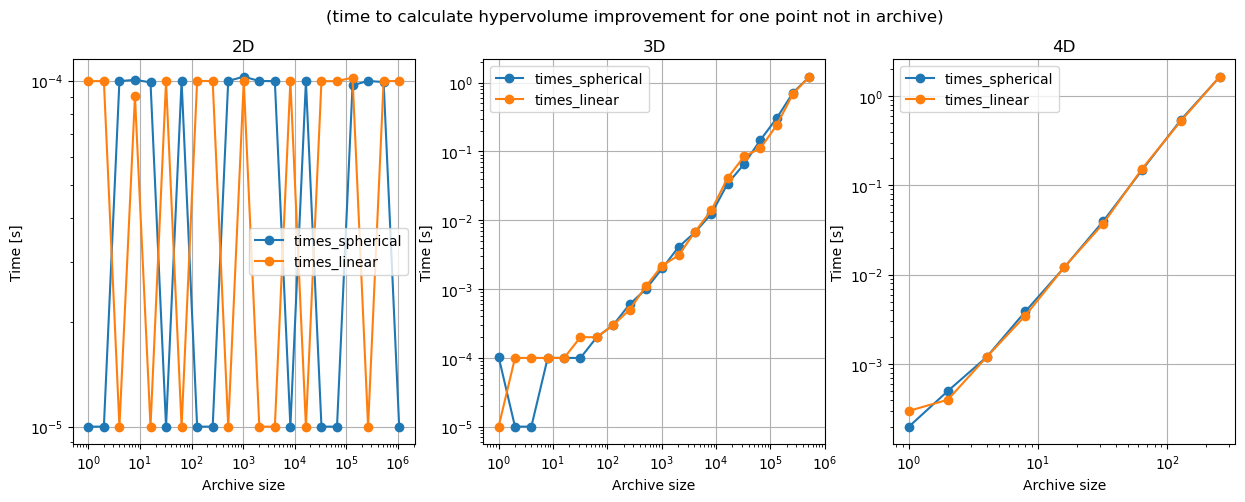

In [16]:
for dim in [2, 3, 4]:
    test_hypervolume_improvement(archive_sizes, time_limit=10, n_dim=dim)
plot_performance(plot_function="hypervolume_improvement",
                 title="(time to calculate hypervolume improvement for one point not in archive)")